In [1]:
import torch
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

from skimage.segmentation import slic
import skimage as ski

In [91]:
ds = datasets.CIFAR10(root=".data", train=False, download=True, transform=T.ToTensor())

Files already downloaded and verified


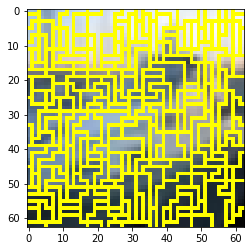

In [96]:
img_np = ds[2][0]
img_np = torch.stack([img_np[0], img_np[1], img_np[2]], dim=2).numpy()
n_segments = 400
compactness = 0.1
s = slic(img_np, n_segments, compactness, start_label=0)
plt.imshow(ski.segmentation.mark_boundaries(img_np, s, mode='subpixel'))

In [106]:
n_segments = 100
compactness = 0.1

# features 
get_avg_color = True
get_std_deviation_color = True
get_centroid = True
get_std_deviation_centroid = True
get_num_pixels = False

In [107]:
img, y = ds[0]
_, dim0, dim1 = img.shape
img_np = torch.stack([img[0], img[1], img[2]], dim=2).numpy()
s = slic(img_np, n_segments, compactness, start_label=0)
g = ski.future.graph.rag_mean_color(img_np, s)
n = g.number_of_nodes()
s1 = np.zeros([n, 3])  # for mean color and std deviation
s2 = np.zeros([n, 3])  # for std deviation
pos1 = np.zeros([n, 2]) # for centroid
pos2 = np.zeros([n, 2]) # for centroid std deviation
num_pixels = np.zeros([n, 1])
for idx in range(dim0 * dim1):
        idx_i, idx_j = idx % dim0, int(idx / dim0)
        node = s[idx_i][idx_j] - 1
        s1[node][0]  += img_np[idx_i][idx_j][0]
        s2[node][0]  += pow(img_np[idx_i][idx_j][0], 2)
        s1[node][1]  += img_np[idx_i][idx_j][1]
        s2[node][1]  += pow(img_np[idx_i][idx_j][1], 2)
        s1[node][2]  += img_np[idx_i][idx_j][2]
        s2[node][2]  += pow(img_np[idx_i][idx_j][2], 2)
        pos1[node][0] += idx_i
        pos1[node][1] += idx_j
        pos2[node][0] += pow(idx_i, 2)
        pos2[node][1] += pow(idx_j, 2)
        num_pixels[node][0] += 1


In [108]:

# computing features
edge_index = torch.from_numpy(np.array(g.edges).T).to(torch.long)
x = []
s1 = s1/num_pixels
if get_avg_color:
    avg_color = torch.from_numpy(s1).to(torch.float)
    x.append(avg_color[:,0])
    x.append(avg_color[:,1])
    x.append(avg_color[:,2])
if get_std_deviation_color:
    s2 = s2/num_pixels
    std_deviation = torch.from_numpy(np.sqrt(s2 - s1*s1)).to(torch.float)
    x.append(std_deviation[:,0])
    x.append(std_deviation[:,1])
    x.append(std_deviation[:,2])
pos1 = pos1/num_pixels
pos = torch.from_numpy(pos1).to(torch.float)
if get_centroid:
    x.append(pos[:,0])
    x.append(pos[:,1])
if get_std_deviation_centroid:
    pos2 = pos2/num_pixels
    std_deviation_centroid = torch.from_numpy(np.abs(np.sqrt(pos2 - pos1*pos1))).to(torch.float)
    x.append(std_deviation_centroid[:,0])
    x.append(std_deviation_centroid[:,1])
if get_num_pixels:
    x.append(torch.from_numpy(num_pixels.flatten()).to(torch.float))
data = Data(x=torch.stack(x, dim=1), edge_index=edge_index, pos=pos, y=y)

Grph with 68 nodes and 176 edges
Label: 3


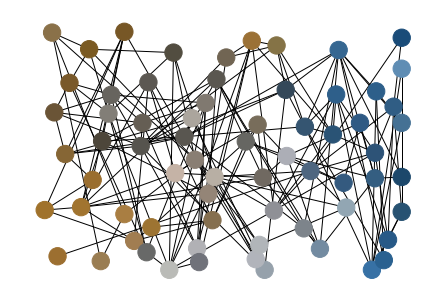

In [118]:
import networkx as nx
from torch_geometric.utils import to_networkx

print(f'Grph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges')
print(f'Label: {data.y}')
color = data.x[:,0:3]
pos = dict(zip(range(data.num_nodes), data.pos.numpy()))
nx.draw(g, pos=pos, node_color=color)

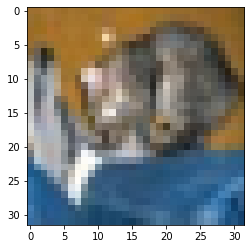

In [117]:
plt.imshow(img_np)